# Проект 1799: "Разработка системы предсказания параметров цифровых схем с использованием методов машинного обучения"  
## Первые шаги, в предсказании Площади и Задержки схем

## Подготовка и исследование данных

### Загрузка и очистка от выбросов

In [99]:
import pandas as pd

In [100]:
data = pd.read_csv('data4.csv') 

In [101]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13824 entries, 0 to 13823
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   File       13824 non-null  object 
 1   Area       13520 non-null  float64
 2   Delay      13520 non-null  float64
 3   embedding  13736 non-null  object 
dtypes: float64(2), object(2)
memory usage: 432.1+ KB


Видим, что имеются пропуски в значениях Area, Delay и embedding. Значения, которые имеют пропуски в этих ячейках, для обучения не подходят. Очистим данные от пропусков. Важно не забыть, что после использования функции(метода) dropna нумерация будет не последовательной, что может привести к ошибкам в будущем. Стоит сразу же это исправить

In [102]:
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)

In [103]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13520 entries, 0 to 13519
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   File       13520 non-null  object 
 1   Area       13520 non-null  float64
 2   Delay      13520 non-null  float64
 3   embedding  13520 non-null  object 
dtypes: float64(2), object(2)
memory usage: 422.6+ KB


Проверим наличие выбросов в значениях параметров Задержки и площади:

In [104]:
print("Максимальная задержка: ", data['Delay'].max())
print("Минимальная задержка: ", data['Delay'].min())
print("Максимальная площадь: ", data['Area'].max())
print("Минимальная площадь: ", data['Area'].min())

Максимальная задержка:  1150.19
Минимальная задержка:  -1000000000.0
Максимальная площадь:  1289.55
Минимальная площадь:  0.0


Видим, что в таблице присутствуют некорректные данные, с площадью равной 0 и устремленным в минус бесконечность временем задержки. Для улучшения качества обучения, необходимо избавиться от таких данных

In [105]:
data.drop(data[data['Delay'] == data['Delay'].min()].index, inplace=True)
data.drop(data[data['Area'] == data['Area'].min()].index, inplace=True)
data.reset_index(drop=True, inplace=True)

In [106]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13214 entries, 0 to 13213
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   File       13214 non-null  object 
 1   Area       13214 non-null  float64
 2   Delay      13214 non-null  float64
 3   embedding  13214 non-null  object 
dtypes: float64(2), object(2)
memory usage: 413.1+ KB


### Проверка корректности данных. Поиск выбросов

В этом месте, необходимо произвести оценку данных. Вывести графическую статистику по Area и Delay. Задача - определить значения, которые являются выбросами и удалить эти строки из DF. Таким образом, данные будут лучше подобраны для обучения

In [107]:
import matplotlib.pyplot as plt # подключаем библиотеку
import numpy as np

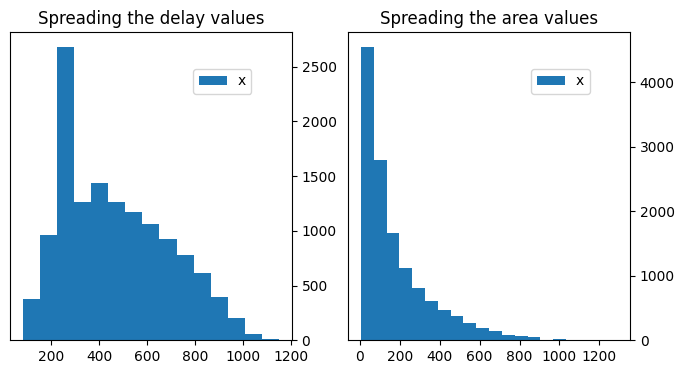

In [108]:
fig, (ax1, ax2) = plt.subplots( #делаем полотно с несколькими графиками
    nrows=1, ncols=2, # расположенными в один ряд два столбца
    figsize=(8, 4) # размер полотна
) #

ax1.hist( # строим второй график - гистограмму
    data['Delay'], bins=15, # задаем данные и диапазоны
    label=('x', 'y') # и подписи данных
)

ax1.legend(loc=(0.65, 0.8)) # отображаем легенду и задаем ее расположение
ax1.set_title('Spreading the delay values') # название второго графика
ax1.yaxis.tick_right() # устанавливаем, что вертикальная ось должна быть справа

ax2.hist( # строим второй график - гистограмму
    data['Area'], bins=20,  # задаем данные и диапазоны
    label=('x', 'y') # и подписи данных
)

ax2.locator_params (axis='x', nbins=10)
ax2.legend(loc=(0.65, 0.8)) # отображаем легенду и задаем ее расположение
ax2.set_title('Spreading the area values') # название второго графика
ax2.yaxis.tick_right() # устанавливаем, что вертикальная ось должна быть справа

plt.show() # отображаем полотна

Видим, что значения задержи, большие 1000 (Если данных будет нехватать, то и большие 750), можно принять за выбросы. Для площади, это значения большие 150.

In [109]:
#С последней версией Датасета нужда в такой отчистке датасета отпала
#data.drop(data[data['Delay'] > 1150].index, inplace=True)
#data.drop(data[data['Area'] > 1000].index, inplace=True)
#data.reset_index(drop=True, inplace=True)

In [110]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13214 entries, 0 to 13213
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   File       13214 non-null  object 
 1   Area       13214 non-null  float64
 2   Delay      13214 non-null  float64
 3   embedding  13214 non-null  object 
dtypes: float64(2), object(2)
memory usage: 413.1+ KB


### Парсинг эмбеддингов

In [111]:
data['embedding'][1231]

'[[0.008626515045762062, -0.01928090490400791, 0.0002276894956594333, -0.007536100223660469, 0.0038559185341000557, -0.07252209633588791, 0.06167784333229065, 0.06307661533355713, -0.11370476335287094, -0.059704117476940155, 0.04233458638191223, -0.07034560292959213, 0.03799484670162201, 0.06712012737989426, -0.02814856544137001, 0.06777746975421906, 0.040482744574546814, 0.021872330456972122, -0.08146925270557404, -0.02386179380118847, 0.03611620515584946, 0.010621929541230202, 0.06631969660520554, -0.009614091366529465, 0.06211685761809349], [0.0017050604801625013, -0.03132391721010208, 0.005080319009721279, -0.0844670906662941, 0.03130161389708519, -0.08162423223257065, 0.03520142287015915, 0.07783395797014236, -0.14199979603290558, -0.06322448700666428, 0.009054210968315601, -0.03465946391224861, 0.033983808010816574, 0.042722854763269424, -0.03780435025691986, 0.053063008934259415, 0.039762433618307114, -0.02704515866935253, -0.08086992800235748, 0.03138844296336174, 0.00785385351

Видим, что эмбеддинги для каждой схемы хранятся в формате string, что не подходит для обучения моделей. Необходимо, преобразовать их в то, чем они являются изначально.  
Напишем программу, которая приведет текстовое представление данных к list, который будет содержать numpy массивы  
Для начала, напишем функцию, которая будет проверять, можно ли приобразовать строку в дробное число (записано ли в строке число)


In [112]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

Далее, напишем функцию, которая распарсит нашу строку на list, который будет содержать numpy массивы

In [113]:
new_embedding = []
for str in data['embedding']:
    result = []
    if '\n' in str:
        res = str.split('\n')
    else:
        res = str.split('], ')
    for mass in res:
        s = mass.replace(', dtype=float32',' ').replace('(', ' ').replace(')',' ').replace(',',' ').replace('[','').replace(']','').split(' ')
        tmp = []
        for word in s:
            if is_number(word):
                tmp.append(float(word))
        result.append(tmp)
    r = [np.array(sublist) for sublist in result]
    new_embedding.append(r)

### Приведение данных в вид, удобный для обучения

Так как каждая схема имеет свое представление в виде графа, возникла проблема, что каждая схема представлена разным количеством векторов длины 4. Т.е. каждая схема описанна массивом, содержащим в себе *n*ое количество массивов длины 4. Так как в процессе обучения, нам требуется, чтобы размерность данных для каждой схемы была единой, то нужно чем-то и до какого-то числа дополнить данные о каждой схеме.  
Идеи:  
* Находим схему, которая представлена в виде максимального количества векторов. Дополняем все остальные схемы до данной размерности
* Дополняем векторами, состоящими из нулей
* Дополняем векторами, состоящими из чисел, являющимися средним значением по всей выборке (средними значениями координат векторов)
* Дополняем векторами, состоящими из чисел, являющимися средним значением по схемам, имеющим наибольшее число векторов в представлении

В данный момент, были реализованы и проверены идеи с дополнением средним значением по всему датасету и дополнение 0. Различия по точности отсутствуют

Ниже, представлена реализация дополнения до размерности максимальной из схем, векторами, состоящими из 0


In [115]:
max_subarrays = max(len(arr) for arr in new_embedding)

for i in range(len(new_embedding)):
    while len(new_embedding[i]) < max_subarrays:
        new_embedding[i] = np.vstack([new_embedding[i], np.zeros(25)])

Ниже, представленна реализация дополнения до размерности максимальной из схем векторами, состоящими из средних значений по всей выборке

In [268]:
lst = []
for i in new_embedding:
    for k in i:
        lst.append(k.mean())
val = np.array(lst).mean()

In [269]:
max_subarrays = max(len(arr) for arr in new_embedding)

for i in range(len(new_embedding)):
    while len(new_embedding[i]) < max_subarrays:
        new_embedding[i] = np.vstack([new_embedding[i], np.full(25, val)])

Так как для большей части алгоритмов машинного обучения данные, представленные в формате двумерного массива не подходят, необходимо, привести их в удобоваримый вид.  
Идеи:  
* Запишем все имеющиеся в представлении вектора друг за другом, по порядку, по которому они хранятся изначально
* Запишем все имеющиеся в представлении вектора друг за другом, перемешав их произвольным образом

Ниже, реализован способ, с записыванием вектором друг за другом в исходном порядке   

In [116]:
for i in range(len(new_embedding)):
    tmp = []
    for j in range (len(new_embedding[i])):
        for k in new_embedding[i][j]:
            tmp.append(k)
    new_embedding[i] = np.array(tmp)

Добавим в наш датасет новый столбец, содержащий уже преобразованные вектора

In [117]:
s = pd.Series(new_embedding)
data['New_embeddings'] = s

Теперь, наши данные выглядят следующим образом

In [118]:
data['New_embeddings']

0        [-0.0021000769920647144, 0.0010819403687492013...
1        [-0.01022262778133154, 0.0025663829874247313, ...
2        [-0.0024822938721626997, 0.000789747922681272,...
3        [-0.008158753626048565, -0.1107431948184967, -...
4        [-0.015282585285604, -0.011996518820524216, 0....
                               ...                        
13209    [-0.001869704807177186, 0.0007680298294872046,...
13210    [-0.014526277780532837, -0.0057861339300870895...
13211    [-0.01359794195741415, -0.009688803926110268, ...
13212    [-0.0021610555704683065, 0.0008954807417467237...
13213    [-0.0011497040977701545, -0.000457222748082131...
Name: New_embeddings, Length: 13214, dtype: object

## Подготовка и обучение моделей

### Крайний этап обработки данных

Загрузить данные в виде одного столбца нашей исходной таблицы и обучать модели на них - нельзя, из-за требований моделей к формату предсавления обучающей выборки. Поэтому, преобразуем наши данные в таблицу

In [119]:
tmp = pd.DataFrame(data['New_embeddings'].values.tolist(), index = data['New_embeddings'].index)
tmp

,0,1,2,3,4,5,6,7,8,9,...,14565,14566,14567,14568,14569,14570,14571,14572,14573,14574
0,-0.002100,0.001082,0.020657,0.035815,-0.037314,-0.028718,0.025886,0.036310,-0.019945,-0.015416,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.010223,0.002566,0.004892,0.025152,-0.037312,-0.033407,0.027481,0.044981,-0.040427,-0.028012,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.002482,0.000790,0.020997,0.037075,-0.037876,-0.029120,0.026221,0.036912,-0.020928,-0.016109,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.008159,-0.110743,-0.002643,0.013058,-0.104931,-0.064674,0.103698,0.108055,-0.064284,-0.094356,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.015283,-0.011997,0.034438,0.048334,-0.037283,-0.032276,0.021332,0.073212,-0.051700,-0.039312,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13209,-0.001870,0.000768,0.020721,0.036355,-0.037810,-0.028715,0.025896,0.035880,-0.021159,-0.015466,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13210,-0.014526,-0.005786,0.012424,0.039612,-0.046715,-0.035427,0.034470,0.065470,-0.033902,-0.028392,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13211,-0.013598,-0.009689,0.017088,0.032926,-0.049214,-0.041021,0.037451,0.065956,-0.035038,-0.022316,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13212,-0.002161,0.000895,0.020505,0.036038,-0.037234,-0.028560,0.025871,0.036086,-0.020147,-0.015063,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Обучение моделей для предсказания параметра 'Area'
Далее, разделим данные на X - матрица объекты-признаки и y - указания учителя  

In [120]:
# Данные, для которых будем проводить нормализацию
X = tmp
y = data['Area']
# Данные, для которых не будем проводить нормализацию
X_0 = tmp
y_0 = data['Area']

Проведем нормализацию данных (А надо ли? (скорее всего надо) - найти подтверждение)

In [121]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X = scaler.fit_transform(X)

Разделим данные на тренировочные и тестовые

In [122]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

X_0_train, X_0_test, y_0_train, y_0_test = train_test_split(X_0, y_0, test_size=0.20, random_state=42)

### Выбор, настройка и обучение моделей

### Градиентный бустинг

In [123]:
#Accuracy: 0.5039494687957289 (learning_rate=0.01, 
                                         #n_estimators=500, 
                                         #max_features='sqrt', 
                                         #random_state=10)
from sklearn.ensemble import GradientBoostingRegressor
gb_regressor = GradientBoostingRegressor(learning_rate=0.075, 
                                         n_estimators=500, 
                                         max_features='sqrt', 
                                         random_state=10)
gb_regressor.fit(X_train, y_train)

# Оценка качества модели на тестовых данных
accuracy = gb_regressor.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.4972337948500767


In [124]:
#Обучение без нормализации
gb_regressor_0 = GradientBoostingRegressor(learning_rate=0.01, 
                                         n_estimators=500, 
                                         max_features='sqrt', 
                                         random_state=10)
gb_regressor_0.fit(X_0_train, y_0_train)

# Оценка качества модели на тестовых данных
accuracy_0 = gb_regressor_0.score(X_0_test, y_0_test)
print("Accuracy:", accuracy_0)

Accuracy: 0.5005523957915659


### Случайный лес

На данный момент, присутствуют трудности с подбором параметров (при некоторых значениях модель обучается бесконечно долго) Вполне возможно, что нет необходимости использовать данную модель

In [26]:
#from sklearn.ensemble import RandomForestRegressor

#rf_regressor = RandomForestRegressor(n_estimators=200, random_state=0, oob_score=True)

#rf_regressor.fit(X_train, y_train)

#accuracy = rf_regressor.score(X_test, y_test)
#print("Accuracy:", accuracy)


### Метод опорных векторов

На данный момент, присутствуют трудности с подбором параметров (при некоторых значениях модель обучается бесконечно долго) Вполне возможно, что нет необходимости использовать данную модель

In [ ]:
#from sklearn.svm import SVR

#svm_regressor = SVR()

#param_grid = { 'C':[0.1,1,100,1000],'kernel':['rbf','poly','sigmoid','linear'],'degree':[1,2,3,4,5,6],'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}

#grid = GridSearchCV(SVR(),param_grid)

#grid.fit(X_train,y_train)

#print(grid.best_params_)
#print(grid.score(X_test,y_test))

### Нейронная сеть

In [125]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential([
    Dense(512, activation='tanh', input_shape=(X_train.shape[1],)),
    Dense(512, activation='tanh'),
    Dense(128, activation='tanh'),
    Dense(128, activation='tanh'),
    Dense(64, activation='tanh'),
    Dense(32, activation='tanh'),
    Dense(1)  
])


model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(X_train, y_train, epochs=150, validation_split=0.2)

loss, mae = model.evaluate(X_test, y_test)
print("Mean Absolute Error on test data:", mae)


Epoch 1/150
265/265 [==============================] - 5s 17ms/step - loss: 61280.1641 - mae: 170.7596 - val_loss: 61636.5781 - val_mae: 166.4028
Epoch 2/150
265/265 [==============================] - 4s 16ms/step - loss: 57863.6250 - mae: 161.1385 - val_loss: 57961.9102 - val_mae: 157.7435
Epoch 3/150
265/265 [==============================] - 4s 17ms/step - loss: 54186.6055 - mae: 152.5600 - val_loss: 55167.6641 - val_mae: 150.9367
Epoch 4/150
265/265 [==============================] - 4s 16ms/step - loss: 51612.0586 - mae: 146.3919 - val_loss: 52735.5820 - val_mae: 145.5830
Epoch 5/150
265/265 [==============================] - 4s 16ms/step - loss: 49346.2422 - mae: 141.4647 - val_loss: 50570.3633 - val_mae: 141.3587
Epoch 6/150
265/265 [==============================] - 4s 16ms/step - loss: 47308.4531 - mae: 137.5090 - val_loss: 48608.7539 - val_mae: 137.9008
Epoch 7/150
265/265 [==============================] - 4s 17ms/step - loss: 45450.9609 - mae: 134.3596 - val_loss: 46823.125

In [126]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

model_2 = Sequential([
    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(X_0_train.shape[1],)),
    Dropout(0.5),
    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(1)  
])

model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])

history_2 = model_2.fit(X_0_train, y_0_train, epochs=300, validation_split=0.2)

loss_2, mae_2 = model_2.evaluate(X_0_test, y_0_test)
print("Mean Absolute Error on test data:", mae_2)


Epoch 1/300
265/265 [==============================] - 12s 44ms/step - loss: 41553.7344 - mae: 138.2048 - val_loss: 24075.7051 - val_mae: 102.2119
Epoch 2/300
265/265 [==============================] - 11s 42ms/step - loss: 26725.4375 - mae: 107.1915 - val_loss: 20873.3887 - val_mae: 93.3224
Epoch 3/300
265/265 [==============================] - 11s 42ms/step - loss: 25471.0215 - mae: 105.6278 - val_loss: 23129.5117 - val_mae: 96.7815
Epoch 4/300
265/265 [==============================] - 11s 42ms/step - loss: 23560.1973 - mae: 102.7005 - val_loss: 20930.9492 - val_mae: 93.4440
Epoch 5/300
265/265 [==============================] - 11s 41ms/step - loss: 24783.3965 - mae: 103.1494 - val_loss: 19254.9980 - val_mae: 90.6159
Epoch 6/300
265/265 [==============================] - 11s 41ms/step - loss: 23783.8281 - mae: 101.2051 - val_loss: 20290.0371 - val_mae: 92.1780
Epoch 7/300
265/265 [==============================] - 11s 42ms/step - loss: 23625.1406 - mae: 101.4659 - val_loss: 22190.7

## Обучение моделей для предсказания параметра 'Delay'
Далее, разделим данные на X - матрица объекты-признаки и y - указания учителя  

In [127]:
# Данные, для которых будем проводить нормализацию
X1 = tmp
y1 = data['Delay']
# Данные, для которых не будем проводить нормализацию
X1_0 = tmp
y1_0 = data['Delay']

Проведем нормализацию данных (А надо ли? (скорее всего надо) - найти подтверждение)

In [128]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X1 = scaler.fit_transform(X1)

Разделим данные на тренировочные и тестовые

In [129]:
from sklearn.model_selection import train_test_split

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.20, random_state=42)

X1_0_train, X1_0_test, y1_0_train, y1_0_test = train_test_split(X1_0, y1_0, test_size=0.20, random_state=42)

### Выбор, настройка и обучение моделей

### Градиентный бустинг

In [130]:
from sklearn.ensemble import GradientBoostingRegressor
gb_regressor1 = GradientBoostingRegressor(learning_rate=0.01, 
                                         n_estimators=500, 
                                         max_features='sqrt', 
                                         random_state=10)
gb_regressor1.fit(X1_train, y1_train)

# Оценка качества модели на тестовых данных
accuracy1 = gb_regressor1.score(X1_test, y1_test)
print("Accuracy:", accuracy1)

Accuracy: 0.5536218074295142


In [131]:
#Без нормализации
from sklearn.ensemble import GradientBoostingRegressor
gb_regressor1_0 = GradientBoostingRegressor(learning_rate=0.01, 
                                         n_estimators=500, 
                                         max_features='sqrt', 
                                         random_state=10)
gb_regressor1_0.fit(X1_0_train, y1_0_train)

# Оценка качества модели на тестовых данных
accuracy1_0 = gb_regressor1_0.score(X1_0_test, y1_0_test)
print("Accuracy:", accuracy1_0)

Accuracy: 0.5535470344934146


### Нейронная сеть

In [132]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model1 = Sequential([
    Dense(512, activation='tanh', input_shape=(X1_train.shape[1],)),
    Dense(512, activation='tanh'),
    Dense(128, activation='tanh'),
    Dense(128, activation='tanh'),
    Dense(64, activation='tanh'),
    Dense(32, activation='tanh'),
    Dense(1)  
])


model1.compile(optimizer='adam', loss='mse', metrics=['mae'])

history1 = model1.fit(X1_train, y1_train, epochs=150, validation_split=0.2)

loss1, mae1 = model1.evaluate(X1_test, y1_test)
print("Mean Absolute Error on test data:", mae1)

Epoch 1/150
265/265 [==============================] - 905s 3s/step - loss: 259806.8750 - mae: 457.9099 - val_loss: 254143.5781 - val_mae: 451.7511
Epoch 2/150
265/265 [==============================] - 3s 13ms/step - loss: 254594.4844 - mae: 451.6676 - val_loss: 247395.1094 - val_mae: 444.0166
Epoch 3/150
265/265 [==============================] - 4s 13ms/step - loss: 243181.1094 - mae: 439.8902 - val_loss: 236059.4375 - val_mae: 432.3111
Epoch 4/150
265/265 [==============================] - 3s 13ms/step - loss: 233050.2812 - mae: 428.6135 - val_loss: 227768.6719 - val_mae: 422.6135
Epoch 5/150
265/265 [==============================] - 4s 13ms/step - loss: 225082.5938 - mae: 419.2131 - val_loss: 220117.4219 - val_mae: 413.4621
Epoch 6/150
265/265 [==============================] - 4s 13ms/step - loss: 217620.1250 - mae: 410.2016 - val_loss: 212869.3281 - val_mae: 404.6020
Epoch 7/150
265/265 [==============================] - 3s 13ms/step - loss: 210521.8594 - mae: 401.4506 - val_lo

In [133]:
#Без нормализации данных
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model1_0 = Sequential([
    Dense(512, activation='tanh', input_shape=(X1_0_train.shape[1],)),
    Dense(512, activation='tanh'),
    Dense(128, activation='tanh'),
    Dense(128, activation='tanh'),
    Dense(64, activation='tanh'),
    Dense(32, activation='tanh'),
    Dense(1)  
])


model1_0.compile(optimizer='adam', loss='mse', metrics=['mae'])

history1_0 = model1_0.fit(X1_0_train, y1_0_train, epochs=150, validation_split=0.2)

loss1_0, mae1_0 = model1_0.evaluate(X1_0_test, y1_0_test)
print("Mean Absolute Error on test data:", mae1_0)

Epoch 1/150
265/265 [==============================] - 5s 19ms/step - loss: 257350.6875 - mae: 456.0885 - val_loss: 251863.7344 - val_mae: 450.2191
Epoch 2/150
265/265 [==============================] - 5s 17ms/step - loss: 249179.8281 - mae: 447.0572 - val_loss: 244067.6562 - val_mae: 441.4760
Epoch 3/150
265/265 [==============================] - 5s 18ms/step - loss: 241508.6719 - mae: 438.3711 - val_loss: 236548.7969 - val_mae: 432.8768
Epoch 4/150
265/265 [==============================] - 5s 17ms/step - loss: 234081.1250 - mae: 429.8391 - val_loss: 229250.4375 - val_mae: 424.3629
Epoch 5/150
265/265 [==============================] - 5s 17ms/step - loss: 226866.5000 - mae: 421.3591 - val_loss: 222159.6562 - val_mae: 415.9245
Epoch 6/150
265/265 [==============================] - 5s 18ms/step - loss: 219857.5000 - mae: 412.9514 - val_loss: 215268.2969 - val_mae: 407.5559
Epoch 7/150
265/265 [==============================] - 4s 17ms/step - loss: 213039.1719 - mae: 404.6240 - val_lo